In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dot_density_mapping import gen_points_in_gdf_polys, gen_random_points_poly

import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# read in geodata
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)

In [3]:
def compile_single_msoa_traveltimes(direction, target_msoa, ttm, msoa_boundaries = msoas):
    '''Compiles a geodataframe of travel times to or from a target msoa.
    target_msoa is an MSOA ID, direction is "from" or "to", ttm is a travel time matrix containing at least "orig_id" and 
    "dest_id", msoa_boundaries is a geodataframe of MSOA boundaries with MSOA IDs as index.'''
    if direction == 'to':
        output = ttm[ttm['dest_id'] == target_msoa]
        output.set_index('orig_id', inplace = True)
    elif direction == 'from':
        output = ttm[ttm['orig_id'] == target_msoa]
        output.set_index('dest_id', inplace = True)
    output = msoa_boundaries.join(output)
    return output

In [4]:
def calculate_provision_ratios(users, targets, ttm, traveltime_column, traveltime_cutoff):
    '''Allocates target amenities to users among n areas using a modified cumulative accessibility measure that accounts 
    for competition effects.
    users is a m x 1 dataframe of the number of users per area for a particular amenity, targets is a n x 1 dataframe of 
    the number of target amenities per area, ttm is a m x n by 3 travel time matrix containing at least "orig_id",  
    "dest_id" and a column of travel times, traveltime_column is the name of the column containing the travel times, and
    traveltime_cutoff is the maximum travel time (inclusive) for a destination to be considered accessible from an origin.'''
    ## convert long-form travel time matrix to wide-form
    ttm = ttm.pivot_table(index = 'orig_id', columns = 'dest_id', values = traveltime_column, 
                          fill_value = np.max(ttm[traveltime_column])*2) # fill in blank cells with very high travel time
    # ensure ttm, users and targets are sorted in the same order
    provision_ratios = users.loc[ttm.index,:].join(targets.loc[ttm.index,:])
    # calculate for each area, how many clients can reach it - note need to transpose the TTM to summarise to destinations instead of origins
    provision_ratios['Users Who Can Access'] = (ttm.transpose() <= traveltime_cutoff).dot(provision_ratios.iloc[:,0])
    # then divide the number of targets in each area evenly among all users who can reach it
    provision_ratios['Targets per User Who Can Access'] = provision_ratios.iloc[:,1] / provision_ratios['Users Who Can Access']
    # then sum up the number of targets per client who can reach each area to each origin
    provision_ratios['Targets within ' + str(traveltime_cutoff) + 'min per User'] = (ttm <= traveltime_cutoff).dot(provision_ratios['Targets per User Who Can Access'])
    # checking that all jobs have been allocated exactly once to reachable workers
    provision_ratios['Targets Allocated to Users'] = provision_ratios['Targets within ' + str(traveltime_cutoff) + 'min per User'] * provision_ratios.iloc[:,0]
    print('All targets allocated exactly once to reachable users:', abs(np.sum(provision_ratios['Targets Allocated to Users']) - np.sum(targets)) < .001)
    
    return provision_ratios

In [5]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [6]:
traveltime_cutoff = 45 # cutoff for considering which MSOAs are accessible from each MSOA

### Figure 4: Travel Times from Stratford

In [7]:
with open('../90 Data/compiled secondary data/ttm_baseline_ampeak', 'rb') as infile:
    ttm_baseline_ampeak = pickle.load(infile)
with open('../90 Data/compiled secondary data/jobcounts', 'rb') as infile:
    jobcounts = pickle.load(infile)
jobcounts = jobcounts.loc[msoas.index,:] # sort the jobcounts according to MSOA ID

In [8]:
# compile travel times from Stratford and job counts
baseline_fastestoption_ampeak_from_stratford = compile_single_msoa_traveltimes('from', 'E02000726', ttm_baseline_ampeak)
baseline_fastestoption_ampeak_from_stratford = baseline_fastestoption_ampeak_from_stratford.join(jobcounts[['Jobs_Total']])

# generate dot density map for jobs
count_per_point = 2000
jobpoints = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, baseline_fastestoption_ampeak_from_stratford['Jobs_Total'], points_per_value = count_per_point))

AM Peak Baseline Fastest Travel Times from Stratford
and Job Distribution (1 point per 2000 jobs)


(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

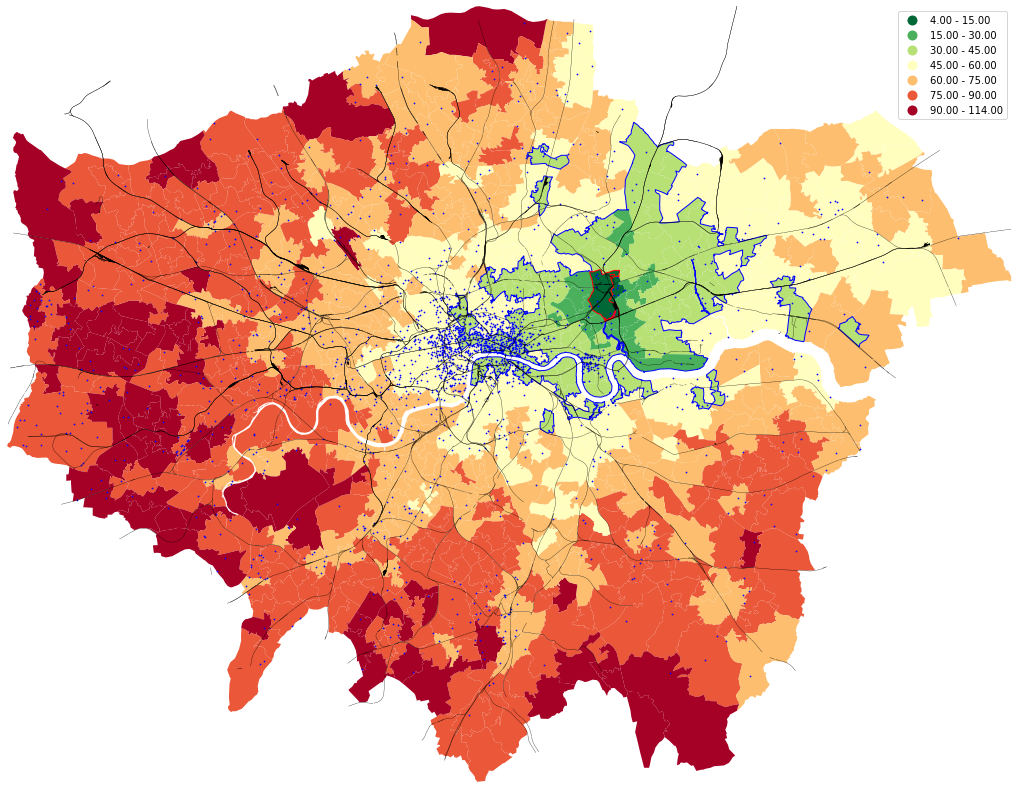

In [9]:
# plot figures
fig02 = plt.figure(figsize = (18,16))
ax02_01 = fig02.add_subplot(1,1,1)
set_zoom(ax02_01, msoas)
baseline_fastestoption_ampeak_from_stratford.plot(column = 'MIN(traveltime)', ax = ax02_01, scheme = 'userdefined', legend = True,
                                                  classification_kwds = {'bins':[15,30,45,60,75,90]}, cmap = 'RdYlGn_r') # travel times
baseline_fastestoption_ampeak_from_stratford[baseline_fastestoption_ampeak_from_stratford['MIN(traveltime)'] <= traveltime_cutoff].dissolve(by = 'orig_id').buffer(1).plot(color = 'None', edgecolor = 'blue', ax = ax02_01)
jobpoints.plot(color = 'blue', ax = ax02_01, markersize = .5) # dot density of jobs
londontube.plot(color = 'black', ax = ax02_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax02_01, linewidth = .3)
baseline_fastestoption_ampeak_from_stratford.loc[['E02000726'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax02_01) # location of Stratford
print('AM Peak Baseline Fastest Travel Times from Stratford\nand Job Distribution (1 point per ' + str(count_per_point) + ' jobs)')
plt.axis('off')

### Figures 5, 6, 7: Job Provision Ratios

In [10]:
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
popcounts = popcounts.loc[msoas.index,:] # sort popcounts by MSOA IDs

In [11]:
## calculate JPRs
jpr_ampeak_baseline = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts[['Jobs_Total']], ttm_baseline_ampeak, 'MIN(traveltime)', traveltime_cutoff)
jpr_ampeak_baseline = msoas.join(jpr_ampeak_baseline)

All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool


In [12]:
# generate dot density map for working-age pop
count_per_point = 2000
poppoints = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, jpr_ampeak_baseline['Pop_WorkingAge'], points_per_value = count_per_point))

Mean Jobs per Working Age Pop: 0.8821806962900559
Number of Working-Age Residents (1000s) who can Reach each MSOA
within 45min, AM Peak Baseline
with Population Distribution (1 point per 2000)
Number of Jobs Provided to every 1000 Working-Age Residents who can
Reach each MSOA within 45min, AM Peak Baseline
with Job Distribution (1 point per 2000)
Job Provision Ratio: Jobs within 45min per Worker, AM Peak Baseline


Text(0.5, 1.0, 'Lorenz Curve of Jobs Allocated to\nPotential Workers')

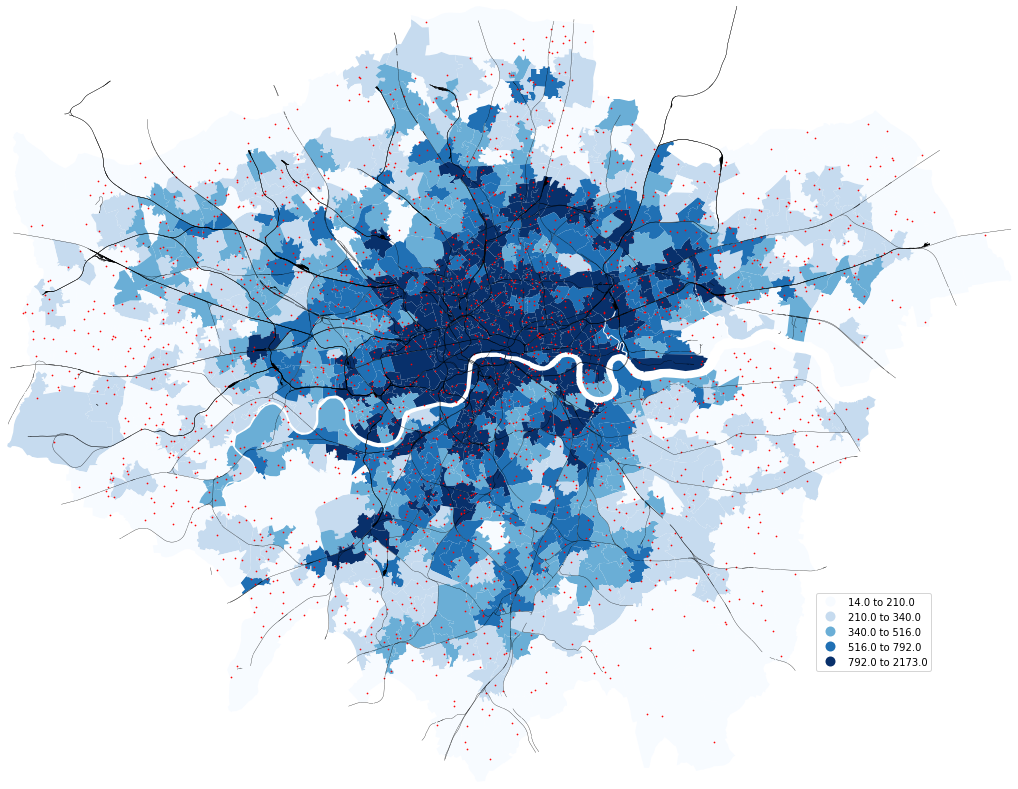

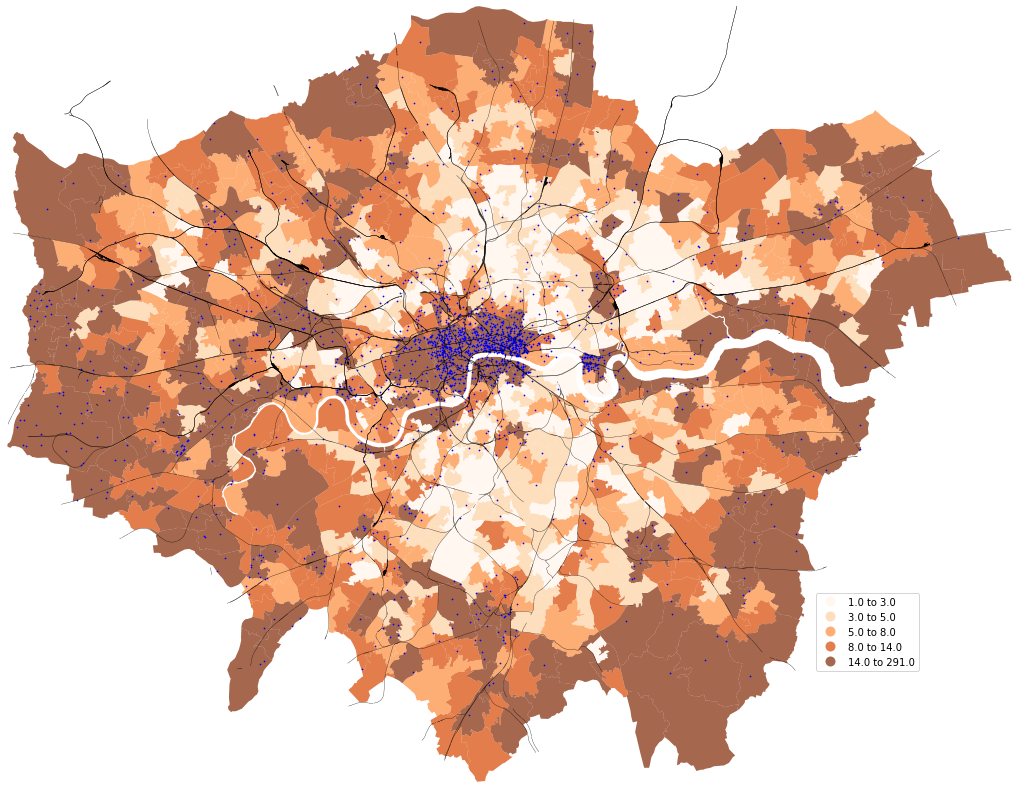

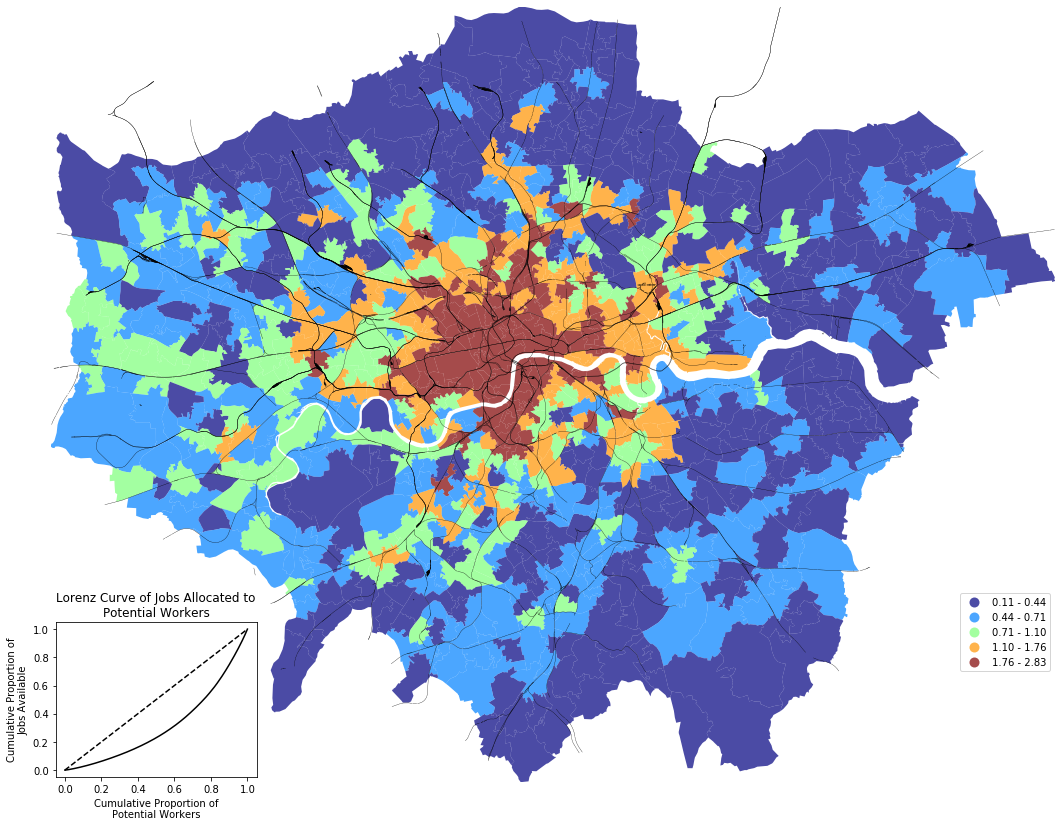

In [13]:
# plot map
mean_jobs_per_workingagepop = jpr_ampeak_baseline['Jobs_Total'].sum() / jpr_ampeak_baseline['Pop_WorkingAge'].sum()
print('Mean Jobs per Working Age Pop:', mean_jobs_per_workingagepop)

fig05_01 = plt.figure(figsize = (18,16))
ax05_01 = fig05_01.add_subplot(1,1,1)
set_zoom(ax05_01, msoas)
k05_01 = 5
jpr_ampeak_baseline.plot(column = 'Users Who Can Access', ax = ax05_01, scheme = 'quantiles', k = k05_01, legend = True, cmap = 'Blues')
poppoints.plot(color = 'Red', ax = ax05_01, markersize = .5)
#set legend labels
legend05_01 = ax05_01.get_legend()
quantiles05_01 = np.quantile(jpr_ampeak_baseline['Users Who Can Access'], [1 / k05_01 * i for i in range(k05_01 + 1)])
for i in range(len(legend05_01.get_texts())):
    legend05_01.get_texts()[i].set_text(str(round(quantiles05_01[i] / 1000,0)) + ' to ' + str(round(quantiles05_01[i+1] / 1000, 0)))
londontube.plot(color = 'black', ax = ax05_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_01, linewidth = .3)
print('Number of Working-Age Residents (1000s) who can Reach each MSOA\nwithin 45min, AM Peak Baseline\nwith Population Distribution (1 point per 2000)')
legend05_01.set_bbox_to_anchor((.8,.25))
plt.axis('off')
    
fig05_02 = plt.figure(figsize = (18,16))
ax05_02 = fig05_02.add_subplot(1,1,1)
set_zoom(ax05_02, msoas)
k05_02 = 5
jpr_ampeak_baseline.plot(column = 'Targets per User Who Can Access', ax = ax05_02, scheme = 'quantiles', k = k05_02, legend = True, cmap = 'Oranges', alpha = .7)
jobpoints.plot(color = 'Blue', ax = ax05_02, markersize = .5)
#set legend labels
legend05_02 = ax05_02.get_legend()
quantiles05_02 = np.quantile(jpr_ampeak_baseline['Targets per User Who Can Access'], [1 / k05_01 * i for i in range(k05_01 + 1)])
for i in range(len(legend05_02.get_texts())):
    legend05_02.get_texts()[i].set_text(str(round(quantiles05_02[i] * 1000,0)) + ' to ' + str(round(quantiles05_02[i+1] * 1000, 0)))
londontube.plot(color = 'black', ax = ax05_02, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_02, linewidth = .3)
print('Number of Jobs Provided to every 1000 Working-Age Residents who can\nReach each MSOA within 45min, AM Peak Baseline\nwith Job Distribution (1 point per 2000)')
legend05_02.set_bbox_to_anchor((.8,.25))
plt.axis('off')

fig05_03 = plt.figure(figsize = (18,16))
ax05_03 = fig05_03.add_subplot(1,1,1)
set_zoom(ax05_03, msoas)
jpr_ampeak_baseline.plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax05_03, 
                         scheme = 'userdefined', 
                         classification_kwds = {'bins': [i * mean_jobs_per_workingagepop for i in [.5,.8,1.25,2]]}, # set breaks to 50%, 80%, 125% and 200% of mean jobs to pop ratio
                         cmap = 'jet', legend = True, alpha = .7)
londontube.plot(color = 'black', ax = ax05_03, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_03, linewidth = .3)
print('Job Provision Ratio: Jobs within ' + str(traveltime_cutoff) + 'min per Worker, AM Peak Baseline')
legend05_03 = ax05_03.get_legend()
legend05_03.set_bbox_to_anchor((1,.25))
plt.axis('off')

# plot Lorenz curve
lorenz_jobsalloc = jpr_ampeak_baseline.sort_values(by = 'Targets within ' + str(traveltime_cutoff) + 'min per User').loc[:,['Pop_WorkingAge', 'Targets Allocated to Users']].cumsum()
ax05_04 = inset_axes(ax05_03, width = '20%', height = '20%', loc = 3)
plt.plot(lorenz_jobsalloc['Pop_WorkingAge']/np.sum(jpr_ampeak_baseline['Pop_WorkingAge']), lorenz_jobsalloc['Targets Allocated to Users']/np.sum(jpr_ampeak_baseline['Targets Allocated to Users']), color = 'black')
ax05_04.plot([0,1], [0,1], 'k--') # plot 1:1 line
ax05_04.set_xlabel('Cumulative Proportion of\nPotential Workers')
ax05_04.set_ylabel('Cumulative Proportion of\nJobs Available')
plt.title('Lorenz Curve of Jobs Allocated to\nPotential Workers')

### Figure 15: Sensitivity of JPRs to Different Travel Time Cutoffs

In [14]:
alternative_cutoffs = [36,40,45,60,75,90]
alternative_jprs = np.ndarray(shape = (len(msoas),len(alternative_cutoffs)))
for i in range(len(alternative_cutoffs)):
    alternative_jprs[:,i] = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts[['Jobs_Total']], ttm_baseline_ampeak, 'MIN(traveltime)', alternative_cutoffs[i]).iloc[:,4]

All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool
All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool
All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool
All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool
All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool
All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool


Job Provision Ratio per MSOA with Alternative Travel Time Cutoffs


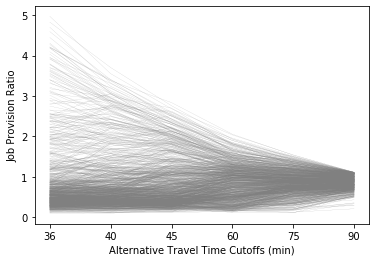

In [15]:
for i in range(len(alternative_jprs)):
    plt.plot(alternative_jprs[i], color = 'grey', linewidth = .1)
plt.xticks([i for i in range(len(alternative_cutoffs))], alternative_cutoffs)
plt.xlabel('Alternative Travel Time Cutoffs (min)')
plt.ylabel('Job Provision Ratio')
print('Job Provision Ratio per MSOA with Alternative Travel Time Cutoffs')

In [16]:
round(pd.DataFrame(alternative_jprs, columns = alternative_cutoffs, index = msoas.index).corr(method = 'pearson'), 2)

36    40    45    60    75    90
36  1.00  0.95  0.86  0.70  0.67  0.57
40  0.95  1.00  0.94  0.78  0.75  0.66
45  0.86  0.94  1.00  0.87  0.83  0.76
60  0.70  0.78  0.87  1.00  0.95  0.92
75  0.67  0.75  0.83  0.95  1.00  0.96
90  0.57  0.66  0.76  0.92  0.96  1.00

### Figure 8: Sectoral Job Distribution

All jobs aggregated correctly to larger sectors: True


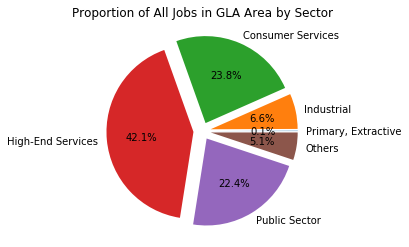

In [17]:
# aggregate 21 industrial sectors to 6 overarching sectors
jobcounts_aggregated_sectors = pd.DataFrame(index = jobcounts.index)
jobcounts_aggregated_sectors['Primary, Extractive'] = np.sum(jobcounts[['Jobs_Agriculture', 'Jobs_Mining']], axis = 1)
jobcounts_aggregated_sectors['Industrial'] = np.sum(jobcounts[['Jobs_Manufacturing',
       'Jobs_Energy_Utilities', 'Jobs_Water_Utilities', 'Jobs_Construction',]], axis = 1)
jobcounts_aggregated_sectors['Consumer Services'] = np.sum(jobcounts[['Jobs_Wholesale_Retail', 'Jobs_Transport_Storage', 
       'Jobs_Accom_Food']], axis = 1)
jobcounts_aggregated_sectors['High-End Services'] = np.sum(jobcounts[['Jobs_Infocomm', 'Jobs_Finance_Insurance', 'Jobs_Real_Estate',
       'Jobs_Professional_Scientific_Technical', 'Jobs_Administrative_Support']], axis = 1)
jobcounts_aggregated_sectors['Public Sector'] = np.sum(jobcounts[['Jobs_Public_Admin_Defence', 'Jobs_Education',
       'Jobs_Health_Social_Work']], axis = 1)
jobcounts_aggregated_sectors['Others'] = np.sum(jobcounts[['Jobs_Arts_Entertainment',
       'Jobs_Other_Services', 'Jobs_Household', 'Jobs_Extraterrestrial_Orgs']], axis = 1)

plt.pie(jobcounts_aggregated_sectors.sum(), labels = jobcounts_aggregated_sectors.columns, autopct='%1.1f%%', explode = [.1 for i in jobcounts_aggregated_sectors.columns])
plt.title('Proportion of All Jobs in GLA Area by Sector')
# check that aggregation did not miss out any jobs
print('All jobs aggregated correctly to larger sectors:', np.sum(np.sum(jobcounts_aggregated_sectors)) == np.sum(jobcounts['Jobs_Total']))

Distribution of Jobs by Aggregated Sector (1 point per 500)


Text(0.5, 1.0, 'Proportion of All Jobs in GLA Area by Sector')

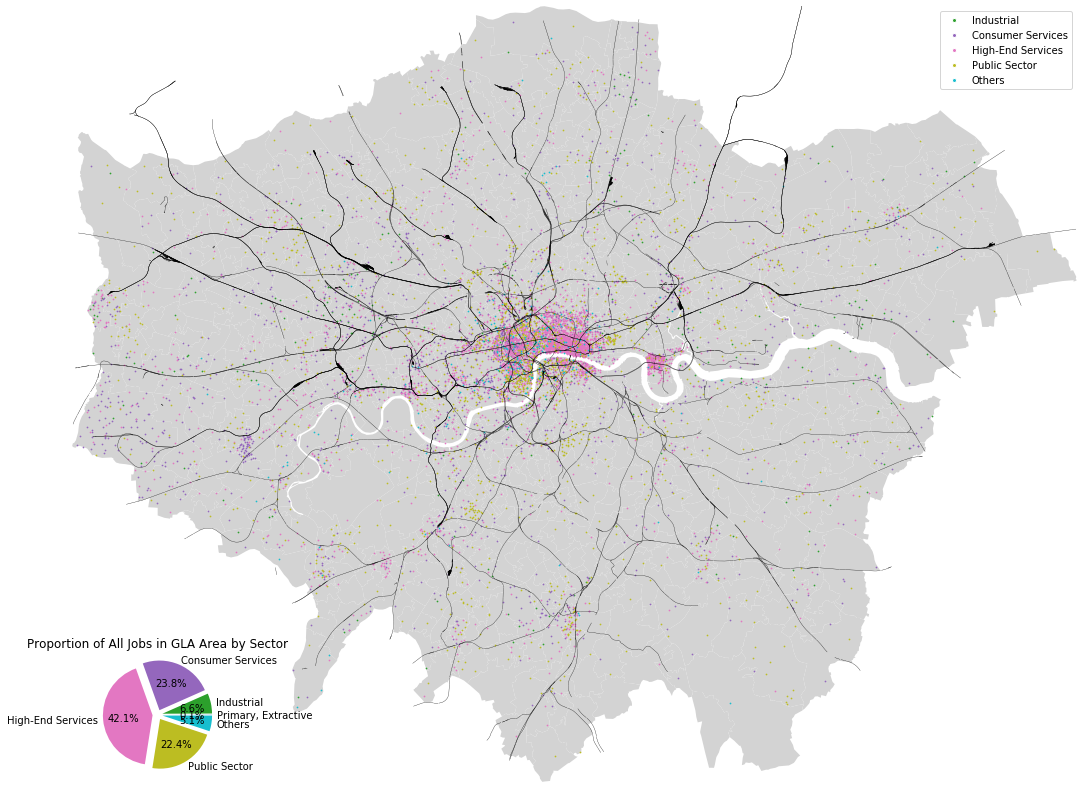

In [18]:
# set colormaps
colormap = []
colors = plt.cm.tab10(np.linspace(0, 1, len(jobcounts_aggregated_sectors.columns))) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))
    
count_per_point = 500
fig12 = plt.figure(figsize = (18,16))
ax12_01 = fig12.add_subplot(111)
set_zoom(ax12_01, msoas)
msoas.plot(ax = ax12_01, color = 'lightgrey')
i = 1 # exclude primary, extractive jobs as there are too few to visualise
for sector in jobcounts_aggregated_sectors.columns[1:]: # exclude primary, extractive jobs as there are too few to visualise
    # generate dot density map
    jobpoints_sector = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, jobcounts_aggregated_sectors[sector], points_per_value = count_per_point))
    jobpoints_sector.plot(markersize = .5, ax = ax12_01, color = colormap[i])
    i += 1

londontube.plot(color = 'black', ax = ax12_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax12_01, linewidth = .3)
print('Distribution of Jobs by Aggregated Sector (1 point per ' + str(count_per_point) + ')')
plt.axis('off')
legend12_01_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label = jobcounts_aggregated_sectors.columns[i],
                                                markerfacecolor = colormap[i], markersize = 4) 
                        for i in range(1,len(jobcounts_aggregated_sectors.columns))]
ax12_01.legend(handles = legend12_01_elements, loc = 'upper right')

ax12_02 = inset_axes(ax12_01, width = '16%', height = '16%', loc = 3)
plt.pie(jobcounts_aggregated_sectors.sum(), labels = jobcounts_aggregated_sectors.columns, autopct='%1.1f%%', explode = [.1 for i in jobcounts_aggregated_sectors.columns], colors = colormap)
plt.title('Proportion of All Jobs in GLA Area by Sector')

### Figure 9: Sectoral JPRs

In [19]:
jpr_sectoral_ampeak_baseline = {sector: None for sector in jobcounts_aggregated_sectors.columns}
for sector in jpr_sectoral_ampeak_baseline.keys():
    jpr_sectoral_ampeak_baseline[sector] = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts_aggregated_sectors[[sector]], ttm_baseline_ampeak, 'MIN(traveltime)', traveltime_cutoff)
    jpr_sectoral_ampeak_baseline[sector] = msoas.join(jpr_sectoral_ampeak_baseline[sector])

All targets allocated exactly once to reachable users: Primary, Extractive    True
dtype: bool
All targets allocated exactly once to reachable users: Industrial    True
dtype: bool
All targets allocated exactly once to reachable users: Consumer Services    True
dtype: bool
All targets allocated exactly once to reachable users: High-End Services    True
dtype: bool
All targets allocated exactly once to reachable users: Public Sector    True
dtype: bool
All targets allocated exactly once to reachable users: Others    True
dtype: bool


Mean Primary, Extractive Jobs per Potential Worker: 0.0005616916578994774
Mean Industrial Jobs per Potential Worker: 0.05785842624544871
Mean Consumer Services Jobs per Potential Worker: 0.21021666062841157
Mean High-End Services Jobs per Potential Worker: 0.3710730972632306
Mean Public Sector Jobs per Potential Worker: 0.19740657502358938
Mean Others Jobs per Potential Worker: 0.04506424547147611


Text(0.5, 1.0, 'Lorenz Curves of Jobs Available to Potential Workers by Sector')

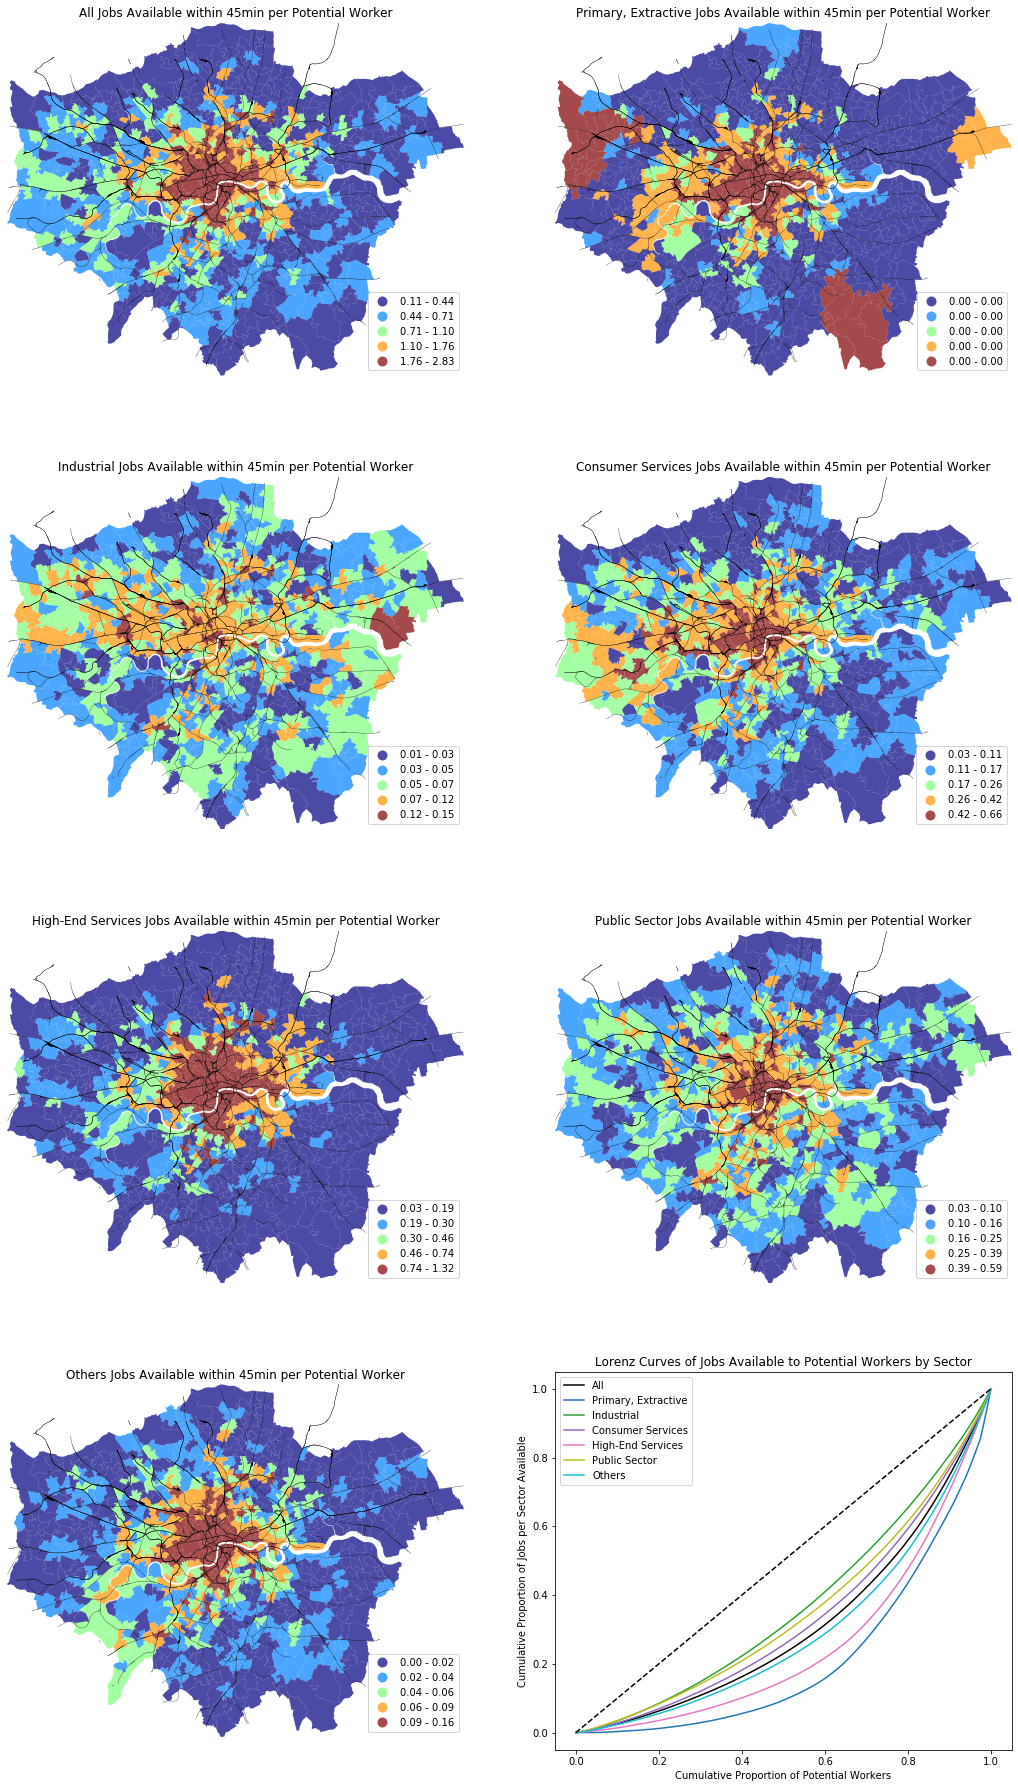

In [20]:
fig10 = plt.figure(figsize = (18, 32))
ax10_01 = fig10.add_subplot(4,2,1)
set_zoom(ax10_01, msoas)
mean_jobs_per_workingagepop = jpr_ampeak_baseline['Jobs_Total'].sum() / jpr_ampeak_baseline['Pop_WorkingAge'].sum()
jpr_ampeak_baseline.plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax10_01, 
                         scheme = 'userdefined', 
                         classification_kwds = {'bins':[i * mean_jobs_per_workingagepop for i in [.5,.8,1.25,2]]}, # set breaks to 50%, 80%, 125% and 200% of mean jobs to pop ratio
                         cmap = 'jet', legend = True, alpha = .7)
londontube.plot(color = 'black', ax = ax10_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax10_01, linewidth = .3)
plt.title('All Jobs Available within ' + str(traveltime_cutoff) + 'min per Potential Worker')
legend10_01 = ax10_01.get_legend()
legend10_01.set_bbox_to_anchor((1,.25))
plt.axis('off')

j = 2
for sector in jpr_sectoral_ampeak_baseline.keys():
    ax10 = fig10.add_subplot(4,2,j)
    set_zoom(ax10, msoas)
    mean_jobs_per_workingagepop = jpr_sectoral_ampeak_baseline[sector][sector].sum() / jpr_sectoral_ampeak_baseline[sector]['Pop_WorkingAge'].sum()
    print('Mean', sector, 'Jobs per Potential Worker:', mean_jobs_per_workingagepop)
    jpr_sectoral_ampeak_baseline[sector].plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax10, 
                                              scheme = 'userdefined', 
                                              classification_kwds = {'bins':[i * mean_jobs_per_workingagepop for i in [.5,.8,1.25,2]]}, # set breaks to 50%, 80%, 125% and 200% of mean jobs to pop ratio
                                              cmap = 'jet', legend = True, alpha = .7)
    londontube.plot(color = 'black', ax = ax10, linewidth = .3) # rail lines
    londonrail.plot(color = 'black', ax = ax10, linewidth = .3)
    plt.title(sector + ' Jobs Available within ' + str(traveltime_cutoff) + 'min per Potential Worker')
    legend10 = ax10.get_legend()
    legend10.set_bbox_to_anchor((1,.25))
    plt.axis('off')
    j += 1

ax10_08 = fig10.add_subplot(4,2,8)
plt.plot(lorenz_jobsalloc['Pop_WorkingAge']/np.sum(jpr_ampeak_baseline['Pop_WorkingAge']), lorenz_jobsalloc['Targets Allocated to Users']/np.sum(jpr_ampeak_baseline['Targets Allocated to Users']), 'k-', label = 'All')
i = 0
for sector in jpr_sectoral_ampeak_baseline.keys():
    lorenz_jobsalloc_sectoral = jpr_sectoral_ampeak_baseline[sector].sort_values(by = 'Targets within ' + str(traveltime_cutoff) + 'min per User').loc[:,['Pop_WorkingAge', 'Targets Allocated to Users']].cumsum()
    plt.plot(lorenz_jobsalloc_sectoral['Pop_WorkingAge']/np.sum(jpr_sectoral_ampeak_baseline[sector]['Pop_WorkingAge']), lorenz_jobsalloc_sectoral['Targets Allocated to Users']/np.sum(jpr_sectoral_ampeak_baseline[sector]['Targets Allocated to Users']), label = sector, color = colormap[i])
    i += 1
ax10_08.plot([0,1], [0,1], 'k--') # plot 1:1 line
plt.legend()
ax10_08.set_xlabel('Cumulative Proportion of Potential Workers')
ax10_08.set_ylabel('Cumulative Proportion of Jobs per Sector Available')
plt.title('Lorenz Curves of Jobs Available to Potential Workers by Sector')

### Figure 10: MSOA Sectoral Dependence for Job Availability

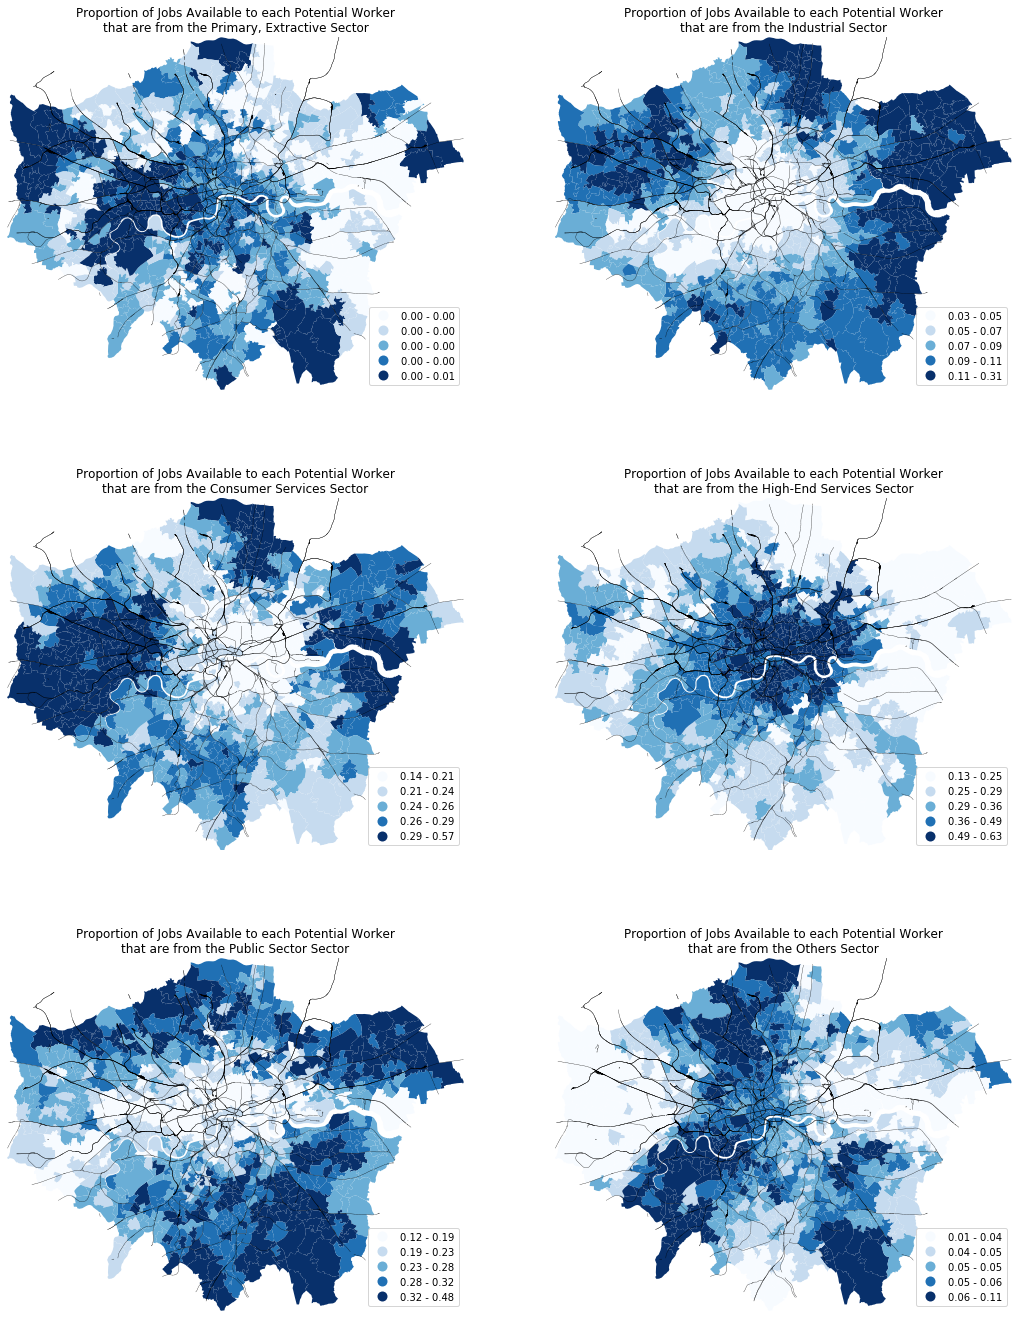

In [21]:
fig11 = plt.figure(figsize = (18, 24))
j = 1
for sector in jpr_sectoral_ampeak_baseline.keys():
    ax11 = fig11.add_subplot(3,2,j)
    set_zoom(ax11, msoas)
    jpr_sectoral_ampeak_baseline[sector]['PC Allocation From Sector'] = jpr_sectoral_ampeak_baseline[sector]['Targets within ' + str(traveltime_cutoff) + 'min per User'] / jpr_ampeak_baseline['Targets within ' + str(traveltime_cutoff) + 'min per User']
    jpr_sectoral_ampeak_baseline[sector].plot(column = 'PC Allocation From Sector', ax = ax11, 
                                              scheme = 'quantiles', 
                                              k = 5,
                                              cmap = 'Blues', legend = True)
    londontube.plot(color = 'black', ax = ax11, linewidth = .3) # rail lines
    londonrail.plot(color = 'black', ax = ax11, linewidth = .3)
    plt.title('Proportion of Jobs Available to each Potential Worker\nthat are from the ' + sector + ' Sector')
    legend11 = ax11.get_legend()
    legend11.set_bbox_to_anchor((1,.25))
    plt.axis('off')
    j += 1

### Write Out Useful Datasets

In [22]:
prepped_data = {'jpr_ampeak_baseline': jpr_ampeak_baseline,
                'jpr_sectoral_ampeak_baseline': jpr_sectoral_ampeak_baseline}

for dataset in prepped_data.keys():
    with open('../90 Data/compiled secondary data/' + dataset, 'wb') as outfile:
        pickle.dump(prepped_data[dataset], outfile)